In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import pylab as pl
import warnings
from time import time

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten,Input,LSTM,Embedding,Dropout,concatenate,BatchNormalization
from tensorflow.keras import regularizers
from sklearn.metrics import classification_report, confusion_matrix, f1_score

warnings.filterwarnings("ignore")

# importing Datasets

In [2]:
y={}
stock_names=["DISH","EA","NFLX","TTWO","VZ","LUMN"]
for i in stock_names:
    y[i]=pd.read_csv("1{}.csv".format(i))
    y[i]=y[i].iloc[:,1:]
    #df1=y[i].iloc[:,:25]
    #df2=y[i].iloc[:,30:]
    #y[i]=pd.concat([df1,df2],axis=1)
    #y[i]=y[i].dropna()
df=pd.concat(y, axis=1)
df=df.reset_index()

# adding sector data and price feature to main dataset

In [3]:
data=pd.read_csv("data.csv")
date=data.iloc[:,0]
data=data.iloc[:,1:]

price=pd.read_csv("price.csv")

# Selecting one of stocks

In [4]:
#Selecting NFLX share
df=pd.concat([df["NFLX"],data],axis=1)
df=df.drop(columns=['signal', 's&p_Volume']).assign(p=df['s&p_Volume'], signal=df['signal'])

df=df.dropna()
df=df.drop(["Open","High","Low","Adj Close","s&p_Open","s&p_Low","s&p_High","s&p_Adj Close"],axis=1)


# Normalizing and splitting data

In [5]:
scaler = MinMaxScaler()
scaler.fit(df.iloc[:,:-1])
scaled_df=scaler.transform(df.iloc[:,:-1])
scaled_df=np.append(scaled_df, df["signal"].values.reshape(-1,1), axis=1)
train_index=round(0.70*len(scaled_df))
test_index=round(0.80*len(scaled_df))
train=scaled_df[:train_index]
valid=scaled_df[train_index:test_index]
test=scaled_df[test_index:]

# Converting dataset into model input and out put

In [6]:
def split_sequences(sequences, n_steps):
    arr = df.to_numpy() 
    size = arr.shape[1]
    X, y = list(), list()
    z=list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix,:size-1], sequences[end_ix, size-1] 
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

window_size=14

X_train,y_train = split_sequences(train, window_size)
X_valid,y_valid = split_sequences(valid, window_size)
X_test,y_test = split_sequences(test, window_size)


# Calculating return of a strategy

In [7]:
def calculate_return_of_strategy(close_list,signal_list):
    trade_list=np.zeros((len(close_list),2))    
    buy_and_sell=[[0,1]]
    for i in range(1,len(close_list)):
        if (signal_list[i]==-1) and (signal_list[i-1]==0)and (buy_and_sell[-1][1]!=-1):
            trade_list[i,0]=close_list[i]
            trade_list[i,1]=signal_list[i]
            buy_and_sell.append((close_list[i],-1))
        if (signal_list[i]==1) and (signal_list[i-1]==0) and (buy_and_sell[-1][1]==-1):
            trade_list[i,0]=close_list[i]
            trade_list[i,1]=signal_list[i]
            buy_and_sell.append((close_list[i],1)) 
    liq=1
    for i in range(1,len(buy_and_sell)-1,2):
        liq=liq*buy_and_sell[i+1][0]/buy_and_sell[i][0]
    return 100*(liq-1),trade_list


# Predictive model structure

In [8]:
from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

time_sensetive_inputs=Input(shape=(window_size,X_train.shape[2]))
dropout=0.2
######LSTM layers########
l1=LSTM(units = 12, return_sequences = True,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                     dropout=dropout,recurrent_dropout=dropout,unroll = True)(time_sensetive_inputs)
l2=LSTM(units = 12, return_sequences = True,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                     dropout=dropout,recurrent_dropout=dropout,unroll = True)(l1)
l3=LSTM(units = 12, return_sequences = False,kernel_regularizer=regularizers.l2(0),recurrent_regularizer = regularizers.l2(0),
                     dropout=dropout,recurrent_dropout=dropout,unroll = True)(l2)

###########Dense layers#############  
D=BatchNormalization()(l3)
D=Dense(15,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))(D)
r=tf.keras.layers.Dropout(0.25)(D)
D=Dense(15,activation='relu')(r)
D=Dense(15,activation='relu')(D)
r=tf.keras.layers.Dropout(0.25)(D)
D=Dense(15,activation='relu',kernel_regularizer=regularizers.l1_l2(l1=5e-5, l2=1e-4),
    bias_regularizer=regularizers.l2(1e-4),
    activity_regularizer=regularizers.l2(1e-5))(r)
r=Dropout(0.2)(D)
outputs=Dense(3,activation="softmax",name="last")(r)
model=Model(inputs=time_sensetive_inputs,outputs=outputs)
# l3_model = Model(inputs,l3)
# d2_model = Model(inputs,d2)
# d4_model = Model(inputs,d4)
opt = tf.keras.optimizers.Adam(learning_rate=0.0007)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy',metrics=["accuracy"])
callback=tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=120)

history1=model.fit(X_train, y_train,batch_size=512 ,callbacks=[callback],epochs=500,validation_data=(X_valid,y_valid),shuffle=False,
                class_weight={0:1.02, 1:0.24, 2:2.04},verbose=1)


#output2_train = model1.predict([new_x_train[:,:,18:],new_x_train[:,:,:18]])
#output2_train = output2_train.argmax(axis=-1)


Epoch 1/500
4/4 [==============================] - 3s 718ms/step - loss: 0.4981 - accuracy: 0.2340 - val_loss: 1.0971 - val_accuracy: 0.8707
Epoch 2/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4962 - accuracy: 0.2730 - val_loss: 1.0926 - val_accuracy: 0.8707
Epoch 3/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4899 - accuracy: 0.3448 - val_loss: 1.0881 - val_accuracy: 0.8707
Epoch 4/500
4/4 [==============================] - 0s 21ms/step - loss: 0.4857 - accuracy: 0.3891 - val_loss: 1.0836 - val_accuracy: 0.8707
Epoch 5/500
4/4 [==============================] - 0s 20ms/step - loss: 0.4817 - accuracy: 0.4557 - val_loss: 1.0786 - val_accuracy: 0.8707
Epoch 6/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4802 - accuracy: 0.5152 - val_loss: 1.0742 - val_accuracy: 0.8707
Epoch 7/500
4/4 [==============================] - 0s 19ms/step - loss: 0.4756 - accuracy: 0.5578 - val_loss: 1.0703 - val_accuracy: 0.8707
Epoch 8/500
4/4 [==

4/4 [==============================] - 0s 17ms/step - loss: 0.4423 - accuracy: 0.7141 - val_loss: 0.9629 - val_accuracy: 0.8707
Epoch 60/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4323 - accuracy: 0.7048 - val_loss: 0.9612 - val_accuracy: 0.8707
Epoch 61/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4432 - accuracy: 0.7019 - val_loss: 0.9590 - val_accuracy: 0.8707
Epoch 62/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4352 - accuracy: 0.7100 - val_loss: 0.9559 - val_accuracy: 0.8707
Epoch 63/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4302 - accuracy: 0.7019 - val_loss: 0.9514 - val_accuracy: 0.8707
Epoch 64/500
4/4 [==============================] - 0s 17ms/step - loss: 0.4313 - accuracy: 0.6704 - val_loss: 0.9453 - val_accuracy: 0.8707
Epoch 65/500
4/4 [==============================] - 0s 16ms/step - loss: 0.4284 - accuracy: 0.6727 - val_loss: 0.9397 - val_accuracy: 0.8707
Epoch 66/500
4/4 [========

4/4 [==============================] - 0s 23ms/step - loss: 0.3836 - accuracy: 0.5187 - val_loss: 0.8062 - val_accuracy: 0.6078
Epoch 118/500
4/4 [==============================] - 0s 21ms/step - loss: 0.3790 - accuracy: 0.5344 - val_loss: 0.8069 - val_accuracy: 0.6078
Epoch 119/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3845 - accuracy: 0.5181 - val_loss: 0.8048 - val_accuracy: 0.6078
Epoch 120/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3821 - accuracy: 0.5228 - val_loss: 0.8024 - val_accuracy: 0.6164
Epoch 121/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3956 - accuracy: 0.5117 - val_loss: 0.8012 - val_accuracy: 0.6164
Epoch 122/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3821 - accuracy: 0.5408 - val_loss: 0.8009 - val_accuracy: 0.6164
Epoch 123/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3862 - accuracy: 0.4912 - val_loss: 0.8002 - val_accuracy: 0.6078
Epoch 124/500
4/4 [=

Epoch 175/500
4/4 [==============================] - 0s 25ms/step - loss: 0.3685 - accuracy: 0.4825 - val_loss: 0.7754 - val_accuracy: 0.4741
Epoch 176/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3595 - accuracy: 0.4924 - val_loss: 0.7749 - val_accuracy: 0.4698
Epoch 177/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3659 - accuracy: 0.4942 - val_loss: 0.7753 - val_accuracy: 0.4828
Epoch 178/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3499 - accuracy: 0.5070 - val_loss: 0.7763 - val_accuracy: 0.4784
Epoch 179/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3623 - accuracy: 0.5029 - val_loss: 0.7773 - val_accuracy: 0.4784
Epoch 180/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3746 - accuracy: 0.4743 - val_loss: 0.7771 - val_accuracy: 0.4569
Epoch 181/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3598 - accuracy: 0.5029 - val_loss: 0.7771 - val_accuracy: 0.4526
Epoch 

Epoch 233/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3562 - accuracy: 0.4732 - val_loss: 0.7769 - val_accuracy: 0.4009
Epoch 234/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3675 - accuracy: 0.4697 - val_loss: 0.7758 - val_accuracy: 0.3922
Epoch 235/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3543 - accuracy: 0.4831 - val_loss: 0.7777 - val_accuracy: 0.4224
Epoch 236/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3581 - accuracy: 0.4597 - val_loss: 0.7775 - val_accuracy: 0.4224
Epoch 237/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3660 - accuracy: 0.4924 - val_loss: 0.7705 - val_accuracy: 0.4353
Epoch 238/500
4/4 [==============================] - 0s 21ms/step - loss: 0.3566 - accuracy: 0.5117 - val_loss: 0.7610 - val_accuracy: 0.4612
Epoch 239/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3558 - accuracy: 0.5216 - val_loss: 0.7551 - val_accuracy: 0.4655
Epoch 

Epoch 291/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3568 - accuracy: 0.4988 - val_loss: 0.7590 - val_accuracy: 0.4138
Epoch 292/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3427 - accuracy: 0.4942 - val_loss: 0.7571 - val_accuracy: 0.4138
Epoch 293/500
4/4 [==============================] - 0s 22ms/step - loss: 0.3457 - accuracy: 0.5018 - val_loss: 0.7564 - val_accuracy: 0.4310
Epoch 294/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3419 - accuracy: 0.4971 - val_loss: 0.7571 - val_accuracy: 0.4440
Epoch 295/500
4/4 [==============================] - 0s 25ms/step - loss: 0.3292 - accuracy: 0.5041 - val_loss: 0.7596 - val_accuracy: 0.4310
Epoch 296/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3268 - accuracy: 0.5163 - val_loss: 0.7630 - val_accuracy: 0.4267
Epoch 297/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3302 - accuracy: 0.4971 - val_loss: 0.7662 - val_accuracy: 0.4095
Epoch 

Epoch 349/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3345 - accuracy: 0.5088 - val_loss: 0.7538 - val_accuracy: 0.4397
Epoch 350/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3353 - accuracy: 0.5146 - val_loss: 0.7551 - val_accuracy: 0.4397
Epoch 351/500
4/4 [==============================] - 0s 24ms/step - loss: 0.3332 - accuracy: 0.5041 - val_loss: 0.7569 - val_accuracy: 0.4353
Epoch 352/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3309 - accuracy: 0.5058 - val_loss: 0.7592 - val_accuracy: 0.4353
Epoch 353/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3385 - accuracy: 0.5093 - val_loss: 0.7612 - val_accuracy: 0.4353
Epoch 354/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3511 - accuracy: 0.4959 - val_loss: 0.7613 - val_accuracy: 0.4440
Epoch 355/500
4/4 [==============================] - 0s 23ms/step - loss: 0.3296 - accuracy: 0.5082 - val_loss: 0.7616 - val_accuracy: 0.4224
Epoch 

# Model results

In [10]:

predictions =model.predict(X_test)
predictions = predictions.argmax(axis=-1)

print("Confusion Matrix:")
print(confusion_matrix(y_test, predictions, labels=[0,1,2]))
print(classification_report(y_test, predictions))

Confusion Matrix:
[[ 28   3   0]
 [ 63 145 228]
 [  0   0  13]]
              precision    recall  f1-score   support

         0.0       0.31      0.90      0.46        31
         1.0       0.98      0.33      0.50       436
         2.0       0.05      1.00      0.10        13

    accuracy                           0.39       480
   macro avg       0.45      0.75      0.35       480
weighted avg       0.91      0.39      0.48       480



# Return of system used predicted signals

In [12]:

predictions =model.predict(X_train)
predictions = predictions.argmax(axis=-1)
predictions[predictions==0]=-1
predictions[predictions==1]=0.5
predictions[predictions==2]=1

train_close=df.iloc[window_size:train_index]["Close"]
print("Train data")
train_return,ter_plot=calculate_return_of_strategy(train_close.values,predictions)
print("return using proposed signal:{:.2f}%".format(train_return))
print("return of buy and hold:{:.2f}%".format(100*(train_close.iloc[-1]-train_close.iloc[0])/train_close.iloc[0]))


predictions =model.predict(X_test)
predictions = predictions.argmax(axis=-1)
predictions[predictions==0]=-1
predictions[predictions==1]=0.5
predictions[predictions==2]=1

test_close=df.iloc[test_index+window_size:]["Close"]
print("Test data")
test_return,tes_plot=calculate_return_of_strategy(test_close.values,predictions)
print("return using proposed signal:{:.2f}%".format(test_return))
print("return of buy and hold:{:.2f}%".format(100*(test_close.iloc[-1]-test_close.iloc[0])/test_close.iloc[0]))


Train data
return using proposed signal:995.27%
return of buy and hold:2712.15%
Test data
return using proposed signal:65.59%
return of buy and hold:76.49%


In [13]:
test_return,l_tes_plot=calculate_return_of_strategy(test_close.values,predictions)

y=np.ones((len(l_tes_plot),2))
t=1
for i in range(1,len(l_tes_plot)):
    y[i,0]=i
    if (l_tes_plot[i-1,0]*l_tes_plot[i-1,1]!=0)and(l_tes_plot[i,0]*l_tes_plot[i,1]!=0):
        t=t*(1+(l_tes_plot[i,0]*l_tes_plot[i,1]-l_tes_plot[i-1,0]*l_tes_plot[i-1,1])/(l_tes_plot[i-1,0]*l_tes_plot[i-1,1]))
    y[i,1]=t

# Portfolio management algorithm (for 2 stocks)

In [14]:
def calculate_return_of_strategy1(close_list,signal_list):
    trade_list=np.zeros((len(close_list),2))    
    buy_and_sell=[[0,1]]
    flag=0
    for i in range(1,len(close_list)):
        trade_list[i,0]=close_list[i]
        if (signal_list[i]==-1) and (signal_list[i-1]==0)and (buy_and_sell[-1][1]!=-1):
            trade_list[i,1]=signal_list[i]
            buy_and_sell.append((close_list[i],-1))
            flag=1
        if flag==1:
            trade_list[i,1]=1
        if (signal_list[i]==1) and (signal_list[i-1]==0) and (buy_and_sell[-1][1]==-1):
            trade_list[i,0]=close_list[i]
            trade_list[i,1]=signal_list[i]
            buy_and_sell.append((close_list[i],1))
            flag=0
    liq=1
    for i in range(1,len(buy_and_sell)-1,2):
        liq=liq*buy_and_sell[i+1][0]/buy_and_sell[i][0]
    return 100*(liq-1),trade_list

In [15]:
def buy_list(test_close,predictions):
    test_return,e_tes_plot=calculate_return_of_strategy1(test_close.values,predictions)

    y_e=np.ones((len(e_tes_plot),2))
    t=1
    for i in range(1,len(e_tes_plot)):
        y_e[i,0]=i
        if (e_tes_plot[i-1,0]*e_tes_plot[i-1,1]!=0)and(e_tes_plot[i,0]*e_tes_plot[i,1]!=0):
            t=t*(1+(e_tes_plot[i,0]*e_tes_plot[i,1]-e_tes_plot[i-1,0]*e_tes_plot[i-1,1])/(e_tes_plot[i-1,0]*e_tes_plot[i-1,1]))
        y_e[i,1]=t
    return y_e ,e_tes_plot  

In [16]:
y_l,l_tes_plot=buy_list(test_close,predictions)
y_e,e_tes_plot=buy_list(test_close,predictions)
y_t,t_tes_plot=buy_list(test_close,predictions)
y_n,n_tes_plot=buy_list(test_close,predictions)
y_v,v_tes_plot=buy_list(test_close,predictions)

In [17]:
num_shares=5
signals=np.zeros((len(l_tes_plot),2,num_shares))
signals[:,:,0]=l_tes_plot
signals[:,:,1]=e_tes_plot
signals[:,:,2]=t_tes_plot
signals[:,:,3]=n_tes_plot
signals[:,:,4]=v_tes_plot

for i in range(len(signals)):
    if signals[i,1,:].sum()!=0:
        summ=signals[i,1,:].sum()
        for j in range (num_shares):
            signals[i,1,j]=signals[i,1,j]/summ
              
t1=np.zeros((len(e_tes_plot)))
t2=np.zeros((len(e_tes_plot)))
t3=np.zeros((len(e_tes_plot)))
t4=np.zeros((len(e_tes_plot)))
t5=np.zeros((len(e_tes_plot)))

for i in range(1,len(e_tes_plot)):

    if (signals[i,0,0]*signals[i,1,0]!=0)and(signals[i-1,0,0]*signals[i-1,1,0]!=0):
        t1[i]=(signals[i,1,0]*(signals[i,0,0]-signals[i-1,0,0])/signals[i-1,0,0])
      
    if (signals[i,0,1]*signals[i,1,1]!=0)and(signals[i-1,0,1]*signals[i-1,1,1]!=0):
        t2[i]=(signals[i,1,1]*(signals[i,0,1]-signals[i-1,0,1])/signals[i-1,0,1])

    if (signals[i,0,2]*signals[i,1,2]!=0)and(signals[i-1,0,2]*signals[i-1,1,2]!=0):
        t3[i]=(signals[i,1,2]*(signals[i,0,2]-signals[i-1,0,2])/signals[i-1,0,2])

    if (signals[i,0,3]*signals[i,1,3]!=0)and(signals[i-1,0,3]*signals[i-1,1,3]!=0):
        t4[i]=(signals[i,1,3]*(signals[i,0,3]-signals[i-1,0,3])/signals[i-1,0,3])

    if (signals[i,0,4]*signals[i,1,4]!=0)and(signals[i-1,0,4]*signals[i-1,1,4]!=0):
        t5[i]=(signals[i,1,4]*(signals[i,0,4]-signals[i-1,0,4])/signals[i-1,0,4])
        
s=np.ones((len(e_tes_plot),num_shares))
w=1
for i in range(1,len(e_tes_plot)):  
    w=w*(1+t1[i]+t2[i]+t3[i]+t4[i]+t5[i])
    s[i,0]=i
    s[i,1]=w
port=pd.DataFrame(signals[:,1,:],columns=["l","e","t","n","v"])
port["Date"]=date.iloc[test_close.index].values
port.to_excel("portfolio.xlsx")
r=pd.DataFrame(s[:,:2],columns=["Date","Portfolio Value"])
r["Date"]=date.iloc[test_close.index].values
#export portfolio stock proportions
r.to_excel("portfoliovalue.xlsx")

# Plotting buy and sell points

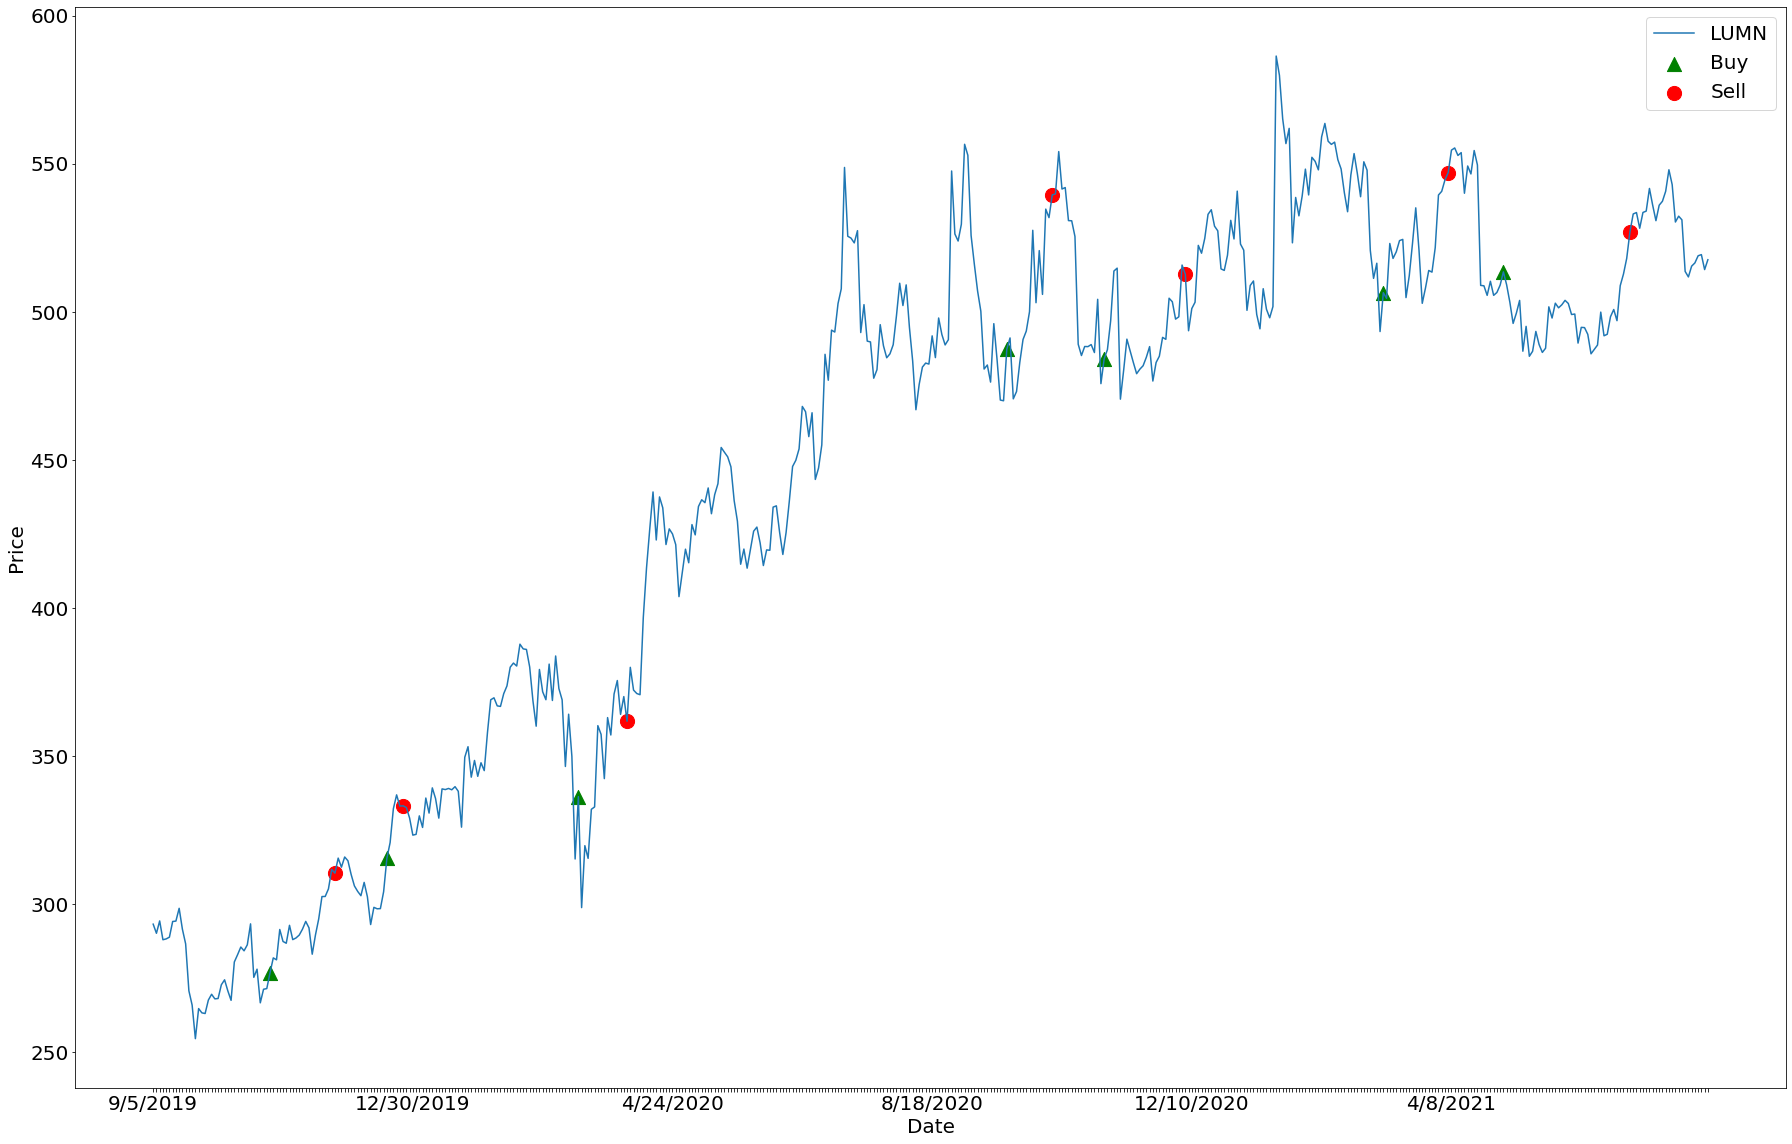

In [18]:
e=pd.DataFrame(test_close)
buy=np.zeros((len(tes_plot)))
sell=np.zeros((len(tes_plot)))

for i in range(len(tes_plot)):
    if tes_plot[i,1]==-1:
        buy[i]=tes_plot[i,0]
    if tes_plot[i,1]==1:
        sell[i]=tes_plot[i,0]   
buy=pd.DataFrame(buy)
buy=buy.replace(0,np.nan)
sell=pd.DataFrame(sell)
sell=sell.replace(0,np.nan)


plt.rcParams["figure.figsize"] = (25, 16)
fig, ax = plt.subplots()
ax.plot(date.iloc[test_close.index],test_close,label="LUMN")
ax.scatter(date.iloc[test_close.index],buy,label="Buy",marker="^",color="green",s=200)
ax.scatter(date.iloc[test_close.index],sell,label="Sell",color="red",s=200)
ax.legend(fontsize=20) # using a size in points
for i, t in enumerate(ax.get_xticklabels()):
    if (i % 80) != 0:
        t.set_visible(False)
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(20)
plt.xlabel('Date', fontsize=20)
plt.ylabel('Price', fontsize=20)
plt.tight_layout()
#plt.savefig("LUMN.png")
plt.show()

# SMOTE sampling (appendix)

In [ ]:
from imblearn.over_sampling import SMOTE
# transform the dataset
oversample = SMOTE()
x_train101 = X_train.reshape(X_train.shape[0],-1)


x_train101, y_train = oversample.fit_resample(x_train101, y_train)
X_train = x_train101.reshape(-1,window_size,train.shape[1])

